# Code for FFI using TLS
* get_stellar_params() - Queries TIC for stellar radius/mass/Teff
* search_for_planets_in_ffi_tls() - Main TLS search with 8-panel diagnostic plots
* search_for_planets_in_ffi_tls_constrained() - Searches near known period
* vet_ffi_detection_tls() - Vetting with SDE and odd-even mismatch checks
* ffi_planet_search_with_catalog_tls() - Complete workflow with catalog constraint

imports 

---


In [2]:
import os
os.environ['LIGHTKURVE_CACHE'] = "C:/lkcache"

import lightkurve as lk
from transitleastsquares import transitleastsquares
from astroquery.mast import Catalogs
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

C:\Users\Coral14\AppData\Local\Temp\ipykernel_17168\1959510364.py:7: DeprecationWarning: the ``nasa_exoplanet_archive`` module has been moved to astroquery.ipac.nexsci.nasa_exoplanet_archive, please update your imports.
  from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive



TESS FFI EXOPLANET SEARCH WITH TRANSIT LEAST SQUARES (TLS)


EXAMPLE 1: Finding TOIs with missing radius
SEARCHING FOR TOIs WITH MISSING PLANET RADIUS

Found 379 TOIs with TRULY MISSING radius!

Top 20 candidates (brightest stars):
    toi     tic_id  pl_orbper  pl_rade  st_tmag tfopwg_disp
1457.01  176860064   6.376817      NaN   7.1145         APC
4391.01   66620917   5.291010      NaN   7.3010          PC
4494.01   40466976  32.535016      NaN   7.3664          PC
1149.01  117789567   2.320242      NaN   7.9172         APC
2183.01 1715469662   6.501126      NaN   8.0348          PC
4175.01  952046774   2.163283      NaN   8.0935          PC
1114.01  409934330   2.488773      NaN   8.1129         APC
2388.01  382625239   1.344272      NaN   8.1150          PC
1986.01  468997317   7.504383      NaN   8.1350         APC
 779.01  374095457   0.783915      NaN   8.2158          PC
 568.01   37575651   9.597198      NaN   8.2866         APC
1531.01  312678993   0.517520      NaN   8.3593

100%|███████████████| 16132/16132 periods | 00:31<00:00


Searching for best T0 for period 6.94903 days

TLS RESULTS:
  Period (TLS): 6.9490 days
  Period (Catalog): 6.3768 days
  Difference: 9.0%
  Duration: 0.13 hours
  Depth: 997770.2 ppm
  SDE: 7.3
  SNR: 2.2
  Transits: 7


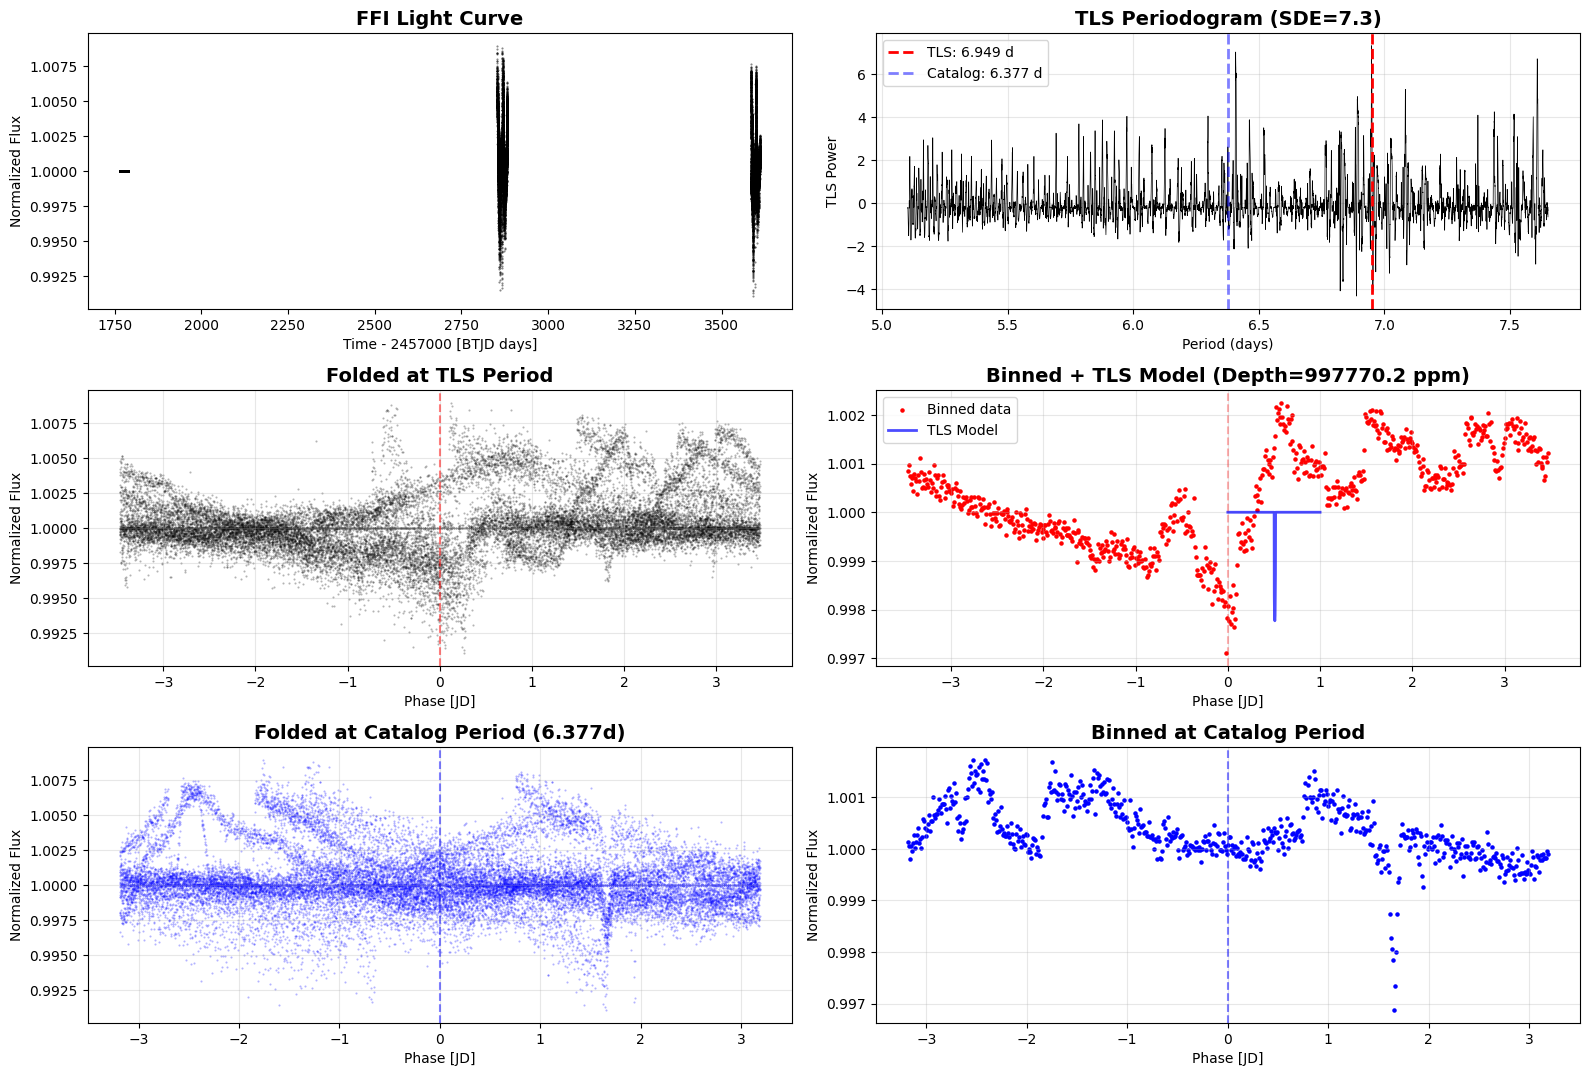


VETTING RESULTS
  176860064: ✗ LIKELY FALSE POSITIVE

Reasons:
  • Depth too large (997770 ppm = 99.8%) - likely eclipsing binary
  • Short duration (0.1h) - near FFI time resolution
  • Moderate SDE (7.3) - needs confirmation
  • Low SNR (2.2) - noisy detection
  • High odd-even mismatch (0.358) - possible binary

FINAL RESULTS:
  Transit depth: 997770.2 ppm
  Period: 6.9490 days
  Duration: 0.13 hours
  SDE: 7.3
  Planet/Star radius ratio: 0.0425
  Estimated planet radius: 4.63 R_Earth


In [3]:
def extract_lightcurve_from_ffi(target, sector=None, cutout_size=15, 
                                 aperture_radius=1, quality_bitmask='default'):
    """
    Extract a light curve from TESS Full Frame Images (FFIs).
    """
    
    # Convert numpy int to Python int
    if isinstance(target, (int, np.integer)):
        target = int(target)
        target = f"TIC {target}"
    
    print(f"Extracting FFI light curve for {target}")
    print("This may take awhile")
    
    try:
        # Search for FFI data
        print("  Searching for FFI data...")
        search_result = lk.search_tesscut(target)
        
        if len(search_result) == 0:
            print(f"    No FFI data found")
            return None
        
        if sector is not None:
            search_result = search_result[search_result.mission == f'TESS Sector {sector}']
            if len(search_result) == 0:
                print(f"    No data in sector {sector}")
                return None
        
        print(f"    Found FFI data in {len(search_result)} sector(s)")
        
        # Download FFI cutouts
        print(f"  Downloading {cutout_size}x{cutout_size} pixel cutouts...")
        tpf_collection = search_result.download_all(cutout_size=cutout_size)
        
        if tpf_collection is None or len(tpf_collection) == 0:
            print("    Download failed")
            return None
        
        # Extract light curves from each sector
        lc_list = []
        
        for tpf in tpf_collection:
            try:
                print(f"  Processing Sector {tpf.sector}...")
                
                # BETTER APERTURE SELECTION
                aperture_mask = None
                
                # Try threshold 5 first (more selective)
                test_mask = tpf.create_threshold_mask(threshold=5, reference_pixel='center')
                if 5 <= test_mask.sum() <= 25:
                    aperture_mask = test_mask
                    print(f"    Using threshold=5 mask")
                
                # If that didn't work, try threshold 3
                if aperture_mask is None:
                    test_mask = tpf.create_threshold_mask(threshold=3, reference_pixel='center')
                    if 5 <= test_mask.sum() <= 30:
                        aperture_mask = test_mask
                        print(f"    Using threshold=3 mask")
                
                # If still nothing, use small circular aperture
                if aperture_mask is None or aperture_mask.sum() == 0:
                    print("    Using small circular aperture (r=2 pixels)")
                    center_row, center_col = tpf.shape[1]//2, tpf.shape[2]//2
                    aperture_mask = np.zeros(tpf.flux[0].shape, dtype=bool)
                    for i in range(tpf.shape[1]):
                        for j in range(tpf.shape[2]):
                            if np.sqrt((i-center_row)**2 + (j-center_col)**2) <= 2:
                                aperture_mask[i, j] = True
                
                print(f"    Aperture size: {aperture_mask.sum()} pixels")
                
                # If aperture is still too large, force smaller
                if aperture_mask.sum() > 30:
                    print(f"    WARNING: Aperture too large ({aperture_mask.sum()}), forcing r=1.5")
                    center_row, center_col = tpf.shape[1]//2, tpf.shape[2]//2
                    aperture_mask = np.zeros(tpf.flux[0].shape, dtype=bool)
                    for i in range(tpf.shape[1]):
                        for j in range(tpf.shape[2]):
                            if np.sqrt((i-center_row)**2 + (j-center_col)**2) <= 1.5:
                                aperture_mask[i, j] = True
                    print(f"    Reduced to {aperture_mask.sum()} pixels")
                
                # Perform aperture photometry
                lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
                
                # Quality filtering
                lc = lc[lc.quality == 0]
                lc = lc.remove_nans()
                
                # Remove extreme outliers BEFORE appending
                lc = lc.remove_outliers(sigma=10)
                
                if len(lc) < 100:
                    print(f"      Too few data points ({len(lc)})")
                    continue
                
                print(f"      Extracted {len(lc)} data points")
                lc_list.append(lc)
                
            except Exception as e:
                print(f"      Error in Sector {tpf.sector}: {e}")
                continue
        
        if len(lc_list) == 0:
            print("    No valid light curves extracted")
            return None
        
        # Stitch light curves together
        print(f"\n  Stitching {len(lc_list)} sector(s) together...")
        combined_lc = lc_list[0]
        for lc in lc_list[1:]:
            combined_lc = combined_lc.append(lc)
        
        # Normalize
        combined_lc = combined_lc.normalize()
        
        # Remove any remaining extreme outliers
        combined_lc = combined_lc.remove_outliers(sigma=7)
        
        print(f"    Final: {len(combined_lc)} points, {combined_lc.time[-1].value - combined_lc.time[0].value:.1f} day baseline")
        
        return combined_lc
        
    except Exception as e:
        print(f"    Extraction failed: {e}")
        return None


def get_stellar_params(tic_id):
    """
    Get stellar parameters from TIC (needed for TLS).
    TLS uses these to compute limb darkening and realistic transit shapes.
    Returns solar values if data is missing/invalid.
    """
    try:
        # Query TIC catalog
        catalog_data = Catalogs.query_object(f"TIC {tic_id}", catalog="TIC", radius=0.001)
        
        if len(catalog_data) == 0:
            print("    Warning: No TIC data found, using solar values")
            return {
                'radius': 1.0,
                'mass': 1.0,
                'teff': 5500,
                'logg': 4.5
            }
        
        # Extract stellar parameters with proper NaN handling
        def get_valid_param(data, key, default):
            try:
                value = data[key][0]
                # Check if masked, NaN, or non-positive
                if np.ma.is_masked(value) or np.isnan(value) or value <= 0:
                    return default
                return float(value)
            except:
                return default
        
        stellar_params = {
            'radius': get_valid_param(catalog_data, 'rad', 1.0),
            'mass': get_valid_param(catalog_data, 'mass', 1.0),
            'teff': get_valid_param(catalog_data, 'Teff', 5500),
            'logg': get_valid_param(catalog_data, 'logg', 4.5)
        }
        
        # If radius or mass are still invalid, use solar values
        if stellar_params['radius'] <= 0 or np.isnan(stellar_params['radius']):
            stellar_params['radius'] = 1.0
        if stellar_params['mass'] <= 0 or np.isnan(stellar_params['mass']):
            stellar_params['mass'] = 1.0
        if stellar_params['teff'] <= 0 or np.isnan(stellar_params['teff']):
            stellar_params['teff'] = 5500
        
        # Check if we're using all defaults
        if (stellar_params['radius'] == 1.0 and stellar_params['mass'] == 1.0 
            and stellar_params['teff'] == 5500):
            print(f"    Stellar params: Using solar values (no TIC data available)")
        else:
            print(f"    Stellar params: R={stellar_params['radius']:.2f} Rsun, M={stellar_params['mass']:.2f} Msun, Teff={stellar_params['teff']:.0f}K")
        
        return stellar_params
        
    except Exception as e:
        print(f"    Warning: Could not get stellar params ({e}), using solar values")
        return {
            'radius': 1.0,
            'mass': 1.0,
            'teff': 5500,
            'logg': 4.5
        }


def search_for_planets_in_ffi_tls(lightcurve, tic_id=None, period_min=0.5, period_max=30, 
                                   detrend=True, plot=True):
    """
    Search for exoplanet transits using Transit Least Squares (TLS).
    TLS is more accurate than BLS because it uses realistic transit shapes.
    
    Parameters:
    -----------
    lightcurve : lightkurve.LightCurve
        The light curve to search
    tic_id : int, optional
        TIC ID for getting stellar parameters
    period_min, period_max : float
        Period search range in days
    detrend : bool
        Whether to flatten/detrend light curve
    plot : bool
        Whether to create diagnostic plots
    """
    
    print("\n" + "="*70)
    print("TRANSIT LEAST SQUARES (TLS) SEARCH")
    print("="*70)
    
    lc = lightcurve.copy()
    
    # Detrending and cleaning
    if detrend:
        print("Detrending light curve...")
        
        # Remove outliers before flattening
        lc = lc.remove_outliers(sigma=5)
        
        # Flatten to remove stellar variability
        median_cadence = np.median(np.diff(lc.time.value))
        window_length_days = max(1.0, period_min * 2.5)
        window_length_cadences = int(window_length_days / median_cadence)
        
        if window_length_cadences % 2 == 0:
            window_length_cadences += 1
        
        window_length_cadences = max(51, min(window_length_cadences, len(lc) // 3))
        
        print(f"  Flattening with window = {window_length_cadences} cadences ({window_length_cadences * median_cadence:.1f} days)")
        lc = lc.flatten(window_length=window_length_cadences)
        
        # Remove outliers again after flattening
        lc = lc.remove_outliers(sigma=4)
        
        # Sigma clipping
        flux_median = np.median(lc.flux.value)
        flux_std = np.std(lc.flux.value)
        mask_good = np.abs(lc.flux.value - flux_median) < 4 * flux_std
        lc = lc[mask_good]
        
        print(f"  After cleaning: {len(lc)} points")
    
    if len(lc) < 500:
        print("  Too few points after cleaning")
        return None
    
    # Get stellar parameters if TIC ID provided
    stellar_params = None
    if tic_id is not None:
        print(f"\nGetting stellar parameters for TIC {tic_id}...")
        stellar_params = get_stellar_params(tic_id)
    else:
        print("\nNo TIC ID provided, using solar values")
        stellar_params = {
            'radius': 1.0,
            'mass': 1.0,
            'teff': 5500,
            'logg': 4.5
        }
    
    # Prepare data for TLS
    time = lc.time.value
    flux = lc.flux.value
    flux_err = lc.flux_err.value
    
    # Run TLS
    print(f"\nRunning TLS (searching periods {period_min:.1f} - {period_max:.1f} days)...")
    print("This may take longer than BLS because TLS fits realistic transit shapes...")
    
    model = transitleastsquares(time, flux, flux_err)
    
    # Set up TLS parameters
    tls_kwargs = {
        'period_min': period_min,
        'period_max': period_max,
        'n_transits_min': 2  # Require at least 2 transits
    }
    
    # Add stellar parameters if available
    if stellar_params is not None:
        tls_kwargs['R_star'] = stellar_params['radius']
        tls_kwargs['M_star'] = stellar_params['mass']
        tls_kwargs['R_star_min'] = stellar_params['radius'] * 0.8
        tls_kwargs['R_star_max'] = stellar_params['radius'] * 1.2
        tls_kwargs['M_star_min'] = stellar_params['mass'] * 0.8
        tls_kwargs['M_star_max'] = stellar_params['mass'] * 1.2
        print(f"  Using stellar params: R={stellar_params['radius']:.2f} Rsun, M={stellar_params['mass']:.2f} Msun")
        print(f"  Using stellar params: R={stellar_params['radius']:.2f} Rsun, M={stellar_params['mass']:.2f} Msun")
    
    # Run the search
    tls_result = model.power(**tls_kwargs)
    
    # Check if TLS found a valid result
    if np.isnan(tls_result.period) or np.isnan(tls_result.T0) or tls_result.SDE < 5:
        print("\n" + "="*70)
        print("⚠️ WARNING: TLS FAILED TO FIND VALID TRANSIT")
        print("="*70)
        print(f"  Period: {tls_result.period} (NaN indicates failure)")
        print(f"  SDE: {tls_result.SDE:.1f} (< 5 indicates weak/no signal)")
        print("\nPossible reasons:")
        print("  • Transit too shallow for FFI data")
        print("  • Period too long (not enough transits)")
        print("  • Data quality issues")
        print("  • Transit not present in this data")
        
        return None
    
    # Extract results
    results = {
        'period': tls_result.period,
        'duration': tls_result.duration,
        't0': tls_result.T0,
        'depth': tls_result.depth,
        'depth_ppm': tls_result.depth * 1e6,
        'power': tls_result.power.max(),  # Peak TLS power (similar to BLS power)
        'SDE': tls_result.SDE,  # Signal Detection Efficiency (TLS-specific metric)
        'snr': tls_result.snr,
        'n_transits': tls_result.distinct_transit_count,
        'odd_even_mismatch': tls_result.odd_even_mismatch,  # TLS-specific: check for binaries
        'rp_rs': tls_result.rp_rs if hasattr(tls_result, 'rp_rs') else np.sqrt(tls_result.depth),  # Planet-to-star radius ratio
        'lightcurve': lc,
        'tls_result': tls_result,
        'stellar_params': stellar_params
    }
    
    print("\n" + "="*70)
    print("TLS RESULTS:")
    print("="*70)
    print(f"  Period: {results['period']:.4f} days")
    print(f"  Duration: {results['duration']*24:.2f} hours")
    print(f"  Transit depth: {results['depth_ppm']:.1f} ppm ({results['depth']*100:.3f}%)")
    print(f"  TLS Power: {results['power']:.1f}")
    print(f"  SDE (Signal Detection Efficiency): {results['SDE']:.1f}")
    print(f"  SNR: {results['snr']:.1f}")
    print(f"  Distinct transits detected: {results['n_transits']}")
    print(f"  Odd-even mismatch: {results['odd_even_mismatch']:.3f} (>0.1 suggests binary)")
    print(f"  Planet/Star radius ratio: {results['rp_rs']:.4f}")
    
    # Plotting
    if plot:
        fig = plt.figure(figsize=(16, 14))
        
        # 1. Full light curve
        ax1 = plt.subplot(4, 2, 1)
        lc.scatter(ax=ax1, s=1, c='black', alpha=0.5)
        ax1.set_title('FFI Light Curve (Cleaned)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time [BTJD]')
        ax1.set_ylabel('Normalized Flux')
        
        # 2. TLS Periodogram
        ax2 = plt.subplot(4, 2, 2)
        ax2.plot(tls_result.periods, tls_result.power, 'k-', lw=0.5)
        ax2.axvline(results['period'], color='red', ls='--', lw=2, 
                    label=f"Best Period = {results['period']:.3f} d")
        ax2.set_xlabel('Period (days)')
        ax2.set_ylabel('TLS Power')
        ax2.set_title(f'TLS Periodogram (SDE={results["SDE"]:.1f})', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        ax2.set_xlim(period_min, period_max)
        
        # 3. Folded light curve (all points)
        ax3 = plt.subplot(4, 2, 3)
        lc_folded = lc.fold(period=results['period'], epoch_time=results['t0'])
        lc_folded.scatter(ax=ax3, s=1, c='black', alpha=0.3)
        ax3.set_title(f"Folded Light Curve (P={results['period']:.4f} d)", 
                     fontsize=14, fontweight='bold')
        ax3.set_xlabel('Phase')
        ax3.set_ylabel('Normalized Flux')
        ax3.axvline(0, color='red', ls='--', alpha=0.5)
        ax3.grid(alpha=0.3)
        
        # 4. Binned folded light curve with TLS model
        ax4 = plt.subplot(4, 2, 4)
        lc_folded_binned = lc_folded.bin(time_bin_size=0.01)
        lc_folded_binned.scatter(ax=ax4, s=20, c='red', label='Binned data')
        
        # Plot TLS model
        phase = tls_result.folded_phase
        model_flux = tls_result.model_folded_model
        sort_idx = np.argsort(phase)
        ax4.plot(phase[sort_idx], model_flux[sort_idx], 'b-', lw=2, label='TLS Model', alpha=0.7)
        
        ax4.set_title(f"Binned Transit + TLS Model (Depth={results['depth_ppm']:.1f} ppm)", 
                     fontsize=14, fontweight='bold')
        ax4.set_xlabel('Phase')
        ax4.set_ylabel('Normalized Flux')
        ax4.axvline(0, color='red', ls='--', alpha=0.3)
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        # 5. Individual transits
        ax5 = plt.subplot(4, 2, 5)
        transit_times = results['t0'] + results['period'] * np.arange(-10, 100)
        transit_times = transit_times[(transit_times >= time[0]) & (transit_times <= time[-1])]
        
        ax5.plot(time, flux, 'k.', ms=1, alpha=0.5)
        for tt in transit_times:
            ax5.axvline(tt, color='red', alpha=0.3, lw=1)
        ax5.set_xlabel('Time [BTJD]')
        ax5.set_ylabel('Normalized Flux')
        ax5.set_title(f'Predicted Transit Times (n={len(transit_times)})', 
                     fontsize=14, fontweight='bold')
        
        # 6. Zoomed first transit
        ax6 = plt.subplot(4, 2, 6)
        if len(transit_times) > 0:
            first_transit = transit_times[0]
            transit_window = results['duration'] * 3
            mask_zoom = (time > first_transit - transit_window) & (time < first_transit + transit_window)
            
            if mask_zoom.sum() > 0:
                ax6.plot(time[mask_zoom], flux[mask_zoom], 'ko', ms=3)
                ax6.axvline(first_transit, color='red', ls='--', alpha=0.5)
                ax6.set_xlabel('Time [BTJD]')
                ax6.set_ylabel('Normalized Flux')
                ax6.set_title('First Transit (Zoomed)', fontsize=14, fontweight='bold')
                ax6.grid(alpha=0.3)
        
        # 7. TLS even/odd transits (checks for eclipsing binaries)
        ax7 = plt.subplot(4, 2, 7)
        if hasattr(tls_result, 'folded_phase'):
            # Even transits
            even_mask = tls_result.transit_number % 2 == 0
            if even_mask.sum() > 0:
                ax7.scatter(tls_result.folded_phase[even_mask], 
                           tls_result.folded_y[even_mask], 
                           s=2, c='blue', alpha=0.5, label='Even transits')
            
            # Odd transits
            odd_mask = tls_result.transit_number % 2 == 1
            if odd_mask.sum() > 0:
                ax7.scatter(tls_result.folded_phase[odd_mask], 
                           tls_result.folded_y[odd_mask], 
                           s=2, c='red', alpha=0.5, label='Odd transits')
            
            ax7.set_xlabel('Phase')
            ax7.set_ylabel('Normalized Flux')
            ax7.set_title(f'Even vs Odd Transits (mismatch={results["odd_even_mismatch"]:.3f})', 
                         fontsize=14, fontweight='bold')
            ax7.legend()
            ax7.grid(alpha=0.3)
        
        # 8. SDE vs period (shows confidence across different periods)
        ax8 = plt.subplot(4, 2, 8)
        if hasattr(tls_result, 'SDE_raw'):
            ax8.plot(tls_result.periods, tls_result.SDE_raw, 'k-', lw=0.5)
            ax8.axvline(results['period'], color='red', ls='--', lw=2)
            ax8.axhline(7, color='orange', ls=':', lw=1, label='SDE=7 (planet threshold)')
            ax8.axhline(9, color='green', ls=':', lw=1, label='SDE=9 (high confidence)')
            ax8.set_xlabel('Period (days)')
            ax8.set_ylabel('SDE')
            ax8.set_title('Signal Detection Efficiency vs Period', fontsize=14, fontweight='bold')
            ax8.legend()
            ax8.grid(alpha=0.3)
            ax8.set_xlim(period_min, period_max)
        
        plt.tight_layout()
        plt.show()
    
    return results


def vet_ffi_detection_tls(results):
    """
    Vet a planet candidate from FFI TLS data.
    TLS provides additional metrics (SDE, odd_even_mismatch) for better vetting.
    """
    
    period = results['period']
    depth_ppm = results['depth_ppm']
    duration_hrs = results['duration'] * 24
    power = results['power']
    snr = results.get('snr', 0)
    sde = results.get('SDE', 0)
    n_transits = results.get('n_transits', 0)
    odd_even = results.get('odd_even_mismatch', 0)

    verdict = "GOOD"
    reasons = []
    
    # 1. Period checks
    if period < 0.5:
        verdict = "BAD"
        reasons.append(f"Period too short ({period:.2f}d) - likely noise")
    
    # FFI cadence artifacts (30 min = 0.0208 days)
    ffi_cadence = 0.0208
    for mult in range(1, 10):
        if abs(period - mult * ffi_cadence) < 0.002:
            verdict = "BAD"
            reasons.append(f"Period matches FFI cadence artifact ({mult}×30min)")
            break
    
    # Sector length artifacts
    sector_length = 27.4
    for mult in [1, 2, 3]:
        if abs(period - mult * sector_length) < 2.0:
            verdict = "BAD"
            reasons.append(f"Period matches sector artifact ({mult}×27.4d)")
            break
    
    # 2. Depth checks
    if depth_ppm > 50000:  # >5%
        verdict = "BAD"
        reasons.append(f"Depth too large ({depth_ppm:.0f} ppm = {depth_ppm/10000:.1f}%) - likely eclipsing binary")
    
    if depth_ppm < 50:  # <50 ppm
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Very shallow ({depth_ppm:.0f} ppm) - hard to detect in FFI")
    
    # 3. Duration checks
    if duration_hrs < 0.5:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Short duration ({duration_hrs:.1f}h) - near FFI time resolution")
    
    if duration_hrs > 12:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Long duration ({duration_hrs:.1f}h) - unusual for planet")
    
    # 4. TLS-specific: SDE check (most important!)
    # SDE > 9: Very likely planet
    # SDE 7-9: Possible planet
    # SDE < 7: Likely false positive
    if sde < 7:
        verdict = "BAD"
        reasons.append(f"Low SDE ({sde:.1f}) - signal not significant")
    elif sde < 9:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Moderate SDE ({sde:.1f}) - needs confirmation")
    else:
        reasons.append(f"High SDE ({sde:.1f}) - strong signal!")
    
    # 5. SNR check
    if snr < 5:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Low SNR ({snr:.1f}) - noisy detection")
    
    # 6. Transit count
    if n_transits < 3:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Only {n_transits} transits - needs more data")
    
    # 7. TLS-specific: Odd-even mismatch check
    # High mismatch (>0.1) suggests eclipsing binary or background eclipsing binary
    if odd_even > 0.1:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"High odd-even mismatch ({odd_even:.3f}) - possible binary")
    
    # If no issues found
    if verdict == "GOOD" and len(reasons) == 1:  # Only SDE comment
        reasons.append(f"Passes all checks: P={period:.2f}d, depth={depth_ppm:.0f}ppm, {n_transits} transits, SDE={sde:.1f}")
    
    return verdict, reasons


def print_ffi_vet_result_tls(target, results):
    """Print vetting results for FFI TLS detection"""
    verdict, reasons = vet_ffi_detection_tls(results)
    
    print("\n" + "="*70)
    print("VETTING RESULTS")
    print("="*70)
    
    if verdict == "GOOD":
        print(f"  {target}: ✓ GOOD CANDIDATE")
    elif verdict == "SUSPICIOUS":
        print(f"  {target}: ⚠ SUSPICIOUS - NEEDS REVIEW")
    else:
        print(f"  {target}: ✗ LIKELY FALSE POSITIVE")
    
    print("\nReasons:")
    for reason in reasons:
        print(f"  • {reason}")
    print("="*70)


def ffi_planet_search_tls(target, period_min=0.5, period_max=30, 
                          cutout_size=15, plot=True):
    """
    Complete FFI exoplanet search using TLS
    """
    
    print("\n" + "="*70)
    print(f"FFI EXOPLANET SEARCH (TLS): {target}")
    print("="*70)
    
    # Extract TIC ID
    tic_id = None
    if isinstance(target, (int, np.integer)):
        tic_id = int(target)
    elif isinstance(target, str) and 'TIC' in target:
        tic_id = int(target.replace('TIC', '').strip())
    
    # Step 1: Extract light curve
    lc = extract_lightcurve_from_ffi(target, cutout_size=cutout_size)
    
    if lc is None:
        print("\n✗ Failed to extract light curve")
        return None
    
    # Step 2: Search with TLS
    results = search_for_planets_in_ffi_tls(lc, tic_id=tic_id,
                                            period_min=period_min, 
                                            period_max=period_max, 
                                            plot=plot)
    
    if results is None:
        print("\n✗ TLS search failed")
        return None
    
    # Step 3: Vet the detection
    print_ffi_vet_result_tls(target, results)
    
    return results


def batch_ffi_search_tls(tic_ids, period_min=0.5, period_max=30, save_results=True):
    """
    Batch FFI search using TLS
    """
    
    all_results = []
    
    print("\n" + "="*70)
    print(f"BATCH FFI SEARCH (TLS): {len(tic_ids)} TARGETS")
    print("="*70)
    
    for i, tic_id in enumerate(tic_ids, 1):
        print(f"\n[{i}/{len(tic_ids)}] Processing TIC {tic_id}...")
        
        try:
            result = ffi_planet_search_tls(tic_id, period_min=period_min, 
                                          period_max=period_max, plot=False)
            
            if result is not None:
                verdict, _ = vet_ffi_detection_tls(result)
                result['verdict'] = verdict
                result['tic_id'] = tic_id
                all_results.append(result)
                
        except Exception as e:
            print(f"✗ Error processing TIC {tic_id}: {e}")
    
    # Summary
    if len(all_results) > 0:
        # Create DataFrame (remove non-serializable objects)
        df_results = []
        for r in all_results:
            df_results.append({
                'tic_id': r['tic_id'],
                'period': r['period'],
                'depth_ppm': r['depth_ppm'],
                'duration_hrs': r['duration'] * 24,
                'SDE': r['SDE'],
                'snr': r['snr'],
                'n_transits': r['n_transits'],
                'odd_even_mismatch': r['odd_even_mismatch'],
                'verdict': r['verdict']
            })
        
        df = pd.DataFrame(df_results)
        df = df.sort_values('SDE', ascending=False)  # Sort by SDE instead of power
        
        print("\n" + "="*70)
        print("BATCH SEARCH COMPLETE")
        print("="*70)
        print(f"\nSuccessfully analyzed: {len(df)} targets\n")
        print(df.to_string(index=False))
        
        n_good = (df['verdict'] == 'GOOD').sum()
        n_susp = (df['verdict'] == 'SUSPICIOUS').sum()
        n_bad = (df['verdict'] == 'BAD').sum()
        
        print(f"\nSUMMARY:")
        print(f"  ✓ Good candidates: {n_good}")
        print(f"  ⚠ Suspicious: {n_susp}")
        print(f"  ✗ False positives: {n_bad}")
        
        if save_results:
            df.to_csv('ffi_tls_results.csv', index=False)
            print(f"\n💾 Results saved to ffi_tls_results.csv")
        
        return df, all_results
    
    return None, None


def search_tois_with_missing_params():
    """
    Find TOIs with missing orbital parameters
    """
    print("=" * 70)
    print("SEARCHING FOR TOIs WITH MISSING ORBITAL PARAMETERS")
    print("=" * 70)
    
    try:
        toi_table = NasaExoplanetArchive.query_criteria(
            table="TOI",
            select="toi, tid, pl_orbper, pl_orbpererr1, pl_rade, pl_radeerr1, st_tmag"
        )
        
        df = toi_table.to_pandas()
        df = df.dropna(subset=['tid'])
        df['tic_id'] = df['tid'].astype(int)
        
        # Filter for TOIs with MISSING or UNCERTAIN parameters
        missing_params = df[
            (df['pl_orbper'].notna()) &
            (
                (df['pl_rade'].isna()) |
                (
                    (df['pl_radeerr1'].notna()) & 
                    (df['pl_rade'].notna()) & 
                    ((df['pl_radeerr1'] / df['pl_rade']) > 0.2)
                ) |
                (
                    (df['pl_orbpererr1'].notna()) & 
                    ((df['pl_orbpererr1'] / df['pl_orbper']) > 0.05)
                )
            )
        ]
        
        missing_params = missing_params.sort_values('st_tmag')
        
        print(f"\nFound {len(missing_params)} TOIs with incomplete/uncertain parameters")
        
        n_missing_radius = missing_params['pl_rade'].isna().sum()
        n_uncertain_radius = 0
        if 'pl_radeerr1' in missing_params.columns:
            uncertain_mask = (
                (missing_params['pl_radeerr1'].notna()) & 
                (missing_params['pl_rade'].notna()) & 
                ((missing_params['pl_radeerr1'] / missing_params['pl_rade']) > 0.2)
            )
            n_uncertain_radius = uncertain_mask.sum()
        
        n_uncertain_period = 0
        if 'pl_orbpererr1' in missing_params.columns:
            uncertain_per_mask = (
                (missing_params['pl_orbpererr1'].notna()) & 
                ((missing_params['pl_orbpererr1'] / missing_params['pl_orbper']) > 0.05)
            )
            n_uncertain_period = uncertain_per_mask.sum()
        
        print("\nCategories:")
        print(f"  - Missing radius: {n_missing_radius}")
        print(f"  - Uncertain radius (>20% error): {n_uncertain_radius}")
        print(f"  - Uncertain period (>5% error): {n_uncertain_period}")

        print("\nTop 20 candidates (brightest stars):")
        display_cols = ['toi', 'tic_id', 'pl_orbper', 'pl_rade', 'st_tmag']
        print(missing_params[display_cols].head(20).to_string(index=False))
        
        return missing_params
        
    except Exception as e:
        print(f"Error: {e}")
        return None


def search_tois_with_truly_missing_params():
    """
    Find TOIs with missing orbital parameters (not just uncertain).
    Focus on missing radius values.
    """
    print("=" * 70)
    print("SEARCHING FOR TOIs WITH MISSING PLANET RADIUS")
    print("=" * 70)
    
    try:
        toi_table = NasaExoplanetArchive.query_criteria(
            table="TOI",
            select="toi, tid, pl_orbper, pl_orbpererr1, pl_rade, pl_radeerr1, st_tmag, tfopwg_disp"
        )
        
        df = toi_table.to_pandas()
        df = df.dropna(subset=['tid'])
        df['tic_id'] = df['tid'].astype(int)
        
        # STRICT FILTER: Only truly missing radius (NaN)
        missing_params = df[
            (df['pl_orbper'].notna()) &
            (df['pl_rade'].isna()) &
            (~df['tfopwg_disp'].isin(['FP', 'FA'])) if 'tfopwg_disp' in df.columns else True
        ]
        
        missing_params = missing_params.sort_values('st_tmag')
        
        print(f"\nFound {len(missing_params)} TOIs with TRULY MISSING radius!")
        
        print("\nTop 20 candidates (brightest stars):")
        display_cols = ['toi', 'tic_id', 'pl_orbper', 'pl_rade', 'st_tmag']
        if 'tfopwg_disp' in missing_params.columns:
            display_cols.append('tfopwg_disp')
        
        print(missing_params[display_cols].head(20).to_string(index=False))
        
        return missing_params
        
    except Exception as e:
        print(f"Error: {e}")
        return None


def search_for_planets_in_ffi_tls_constrained(lightcurve, tic_id=None, known_period=None,
                                               period_min=0.5, period_max=30, 
                                               detrend=True, plot=True):
    """
    TLS search with optional period constraint.
    If known_period is provided, searches tightly around it.
    """
    
    print("\n" + "="*70)
    print("TRANSIT LEAST SQUARES (TLS) SEARCH - CONSTRAINED")
    print("="*70)
    
    lc = lightcurve.copy()
    
    # Detrending
    if detrend:
        print("Detrending light curve...")
        lc = lc.remove_outliers(sigma=5)
        
        median_cadence = np.median(np.diff(lc.time.value))
        
        if known_period is not None:
            window_length_days = max(2.0, known_period * 3)
            print(f"  Using known period {known_period:.2f}d to set window")
        else:
            window_length_days = max(1.0, period_min * 2.5)
        
        window_length_cadences = int(window_length_days / median_cadence)
        if window_length_cadences % 2 == 0:
            window_length_cadences += 1
        window_length_cadences = max(51, min(window_length_cadences, len(lc) // 3))
        
        print(f"  Flattening with window = {window_length_cadences} cadences")
        lc = lc.flatten(window_length=window_length_cadences)
        lc = lc.remove_outliers(sigma=4)
        
        flux_median = np.median(lc.flux.value)
        flux_std = np.std(lc.flux.value)
        mask_good = np.abs(lc.flux.value - flux_median) < 4 * flux_std
        lc = lc[mask_good]
        
        print(f"  After cleaning: {len(lc)} points")
    
    if len(lc) < 500:
        print("  Too few points after cleaning")
        return None
    
    # Get stellar parameters
    stellar_params = None
    if tic_id is not None:
        print(f"\nGetting stellar parameters for TIC {tic_id}...")
        stellar_params = get_stellar_params(tic_id)
    else:
        print("\nNo TIC ID provided, using solar values")
        stellar_params = {
            'radius': 1.0,
            'mass': 1.0,
            'teff': 5500,
            'logg': 4.5
        }
    
    time = lc.time.value
    flux = lc.flux.value
    flux_err = lc.flux_err.value
    
    # Adjust period search range if we have a known period
    if known_period is not None:
        period_min = known_period * 0.8
        period_max = known_period * 1.2
        print(f"Constrained search: {period_min:.2f} - {period_max:.2f} days (±20% of {known_period:.2f}d)")
    else:
        print(f"Unconstrained search: {period_min:.1f} - {period_max:.1f} days")
    
    # Run TLS
    print("\nRunning TLS...")
    model = transitleastsquares(time, flux, flux_err)
    
    tls_kwargs = {
        'period_min': period_min,
        'period_max': period_max,
        'n_transits_min': 2
    }
    
    if stellar_params is not None:
        tls_kwargs['R_star'] = stellar_params['radius']
        tls_kwargs['M_star'] = stellar_params['mass']
        tls_kwargs['R_star_min'] = stellar_params['radius'] * 0.8
        tls_kwargs['R_star_max'] = stellar_params['radius'] * 1.2
        tls_kwargs['M_star_min'] = stellar_params['mass'] * 0.8
        tls_kwargs['M_star_max'] = stellar_params['mass'] * 1.2
    
    tls_result = model.power(**tls_kwargs)
    
    # Check if TLS found a valid result
    if np.isnan(tls_result.period) or np.isnan(tls_result.T0) or tls_result.SDE < 5:
        print("\n" + "="*70)
        print("⚠️ WARNING: TLS FAILED TO FIND VALID TRANSIT")
        print("="*70)
        print(f"  Period: {tls_result.period} (NaN indicates failure)")
        print(f"  SDE: {tls_result.SDE:.1f} (< 5 indicates weak/no signal)")
        print("\nPossible reasons:")
        print("  • Transit too shallow for FFI data")
        print("  • Period too long (not enough transits)")
        print("  • Data quality issues")
        print("  • Transit not present in this data")
        
        if known_period is not None:
            print(f"\nTry: Manually fold at catalog period {known_period:.3f}d to check visually")
        
        return None
    
    results = {
        'period': tls_result.period,
        'duration': tls_result.duration,
        't0': tls_result.T0,
        'depth': tls_result.depth,
        'depth_ppm': tls_result.depth * 1e6,
        'power': tls_result.power.max(),
        'SDE': tls_result.SDE,
        'snr': tls_result.snr,
        'n_transits': tls_result.distinct_transit_count,
        'odd_even_mismatch': tls_result.odd_even_mismatch,
        'rp_rs': tls_result.rp_rs if hasattr(tls_result, 'rp_rs') else np.sqrt(tls_result.depth),
        'lightcurve': lc,
        'tls_result': tls_result,
        'stellar_params': stellar_params,
        'known_period': known_period
    }
    
    print("\n" + "="*70)
    print("TLS RESULTS:")
    print("="*70)
    print(f"  Period (TLS): {results['period']:.4f} days")
    if known_period is not None:
        diff = abs(results['period'] - known_period)
        pct_diff = (diff / known_period) * 100
        print(f"  Period (Catalog): {known_period:.4f} days")
        print(f"  Difference: {pct_diff:.1f}%")
    print(f"  Duration: {results['duration']*24:.2f} hours")
    print(f"  Depth: {results['depth_ppm']:.1f} ppm")
    print(f"  SDE: {results['SDE']:.1f}")
    print(f"  SNR: {results['snr']:.1f}")
    print(f"  Transits: {results['n_transits']}")
    
    # Plotting
    if plot:
        fig = plt.figure(figsize=(16, 14))
        
        ax1 = plt.subplot(4, 2, 1)
        lc.scatter(ax=ax1, s=1, c='black', alpha=0.5)
        ax1.set_title('FFI Light Curve', fontsize=14, fontweight='bold')
        
        ax2 = plt.subplot(4, 2, 2)
        ax2.plot(tls_result.periods, tls_result.power, 'k-', lw=0.5)
        ax2.axvline(results['period'], color='red', ls='--', lw=2, 
                    label=f"TLS: {results['period']:.3f} d")
        if known_period is not None:
            ax2.axvline(known_period, color='blue', ls='--', lw=2, alpha=0.5,
                       label=f"Catalog: {known_period:.3f} d")
        ax2.set_xlabel('Period (days)')
        ax2.set_ylabel('TLS Power')
        ax2.set_title(f'TLS Periodogram (SDE={results["SDE"]:.1f})', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        ax3 = plt.subplot(4, 2, 3)
        lc_folded = lc.fold(period=results['period'], epoch_time=results['t0'])
        lc_folded.scatter(ax=ax3, s=1, c='black', alpha=0.3)
        ax3.set_title(f"Folded at TLS Period", fontsize=14, fontweight='bold')
        ax3.axvline(0, color='red', ls='--', alpha=0.5)
        ax3.grid(alpha=0.3)
        
        ax4 = plt.subplot(4, 2, 4)
        lc_folded_binned = lc_folded.bin(time_bin_size=0.01)
        lc_folded_binned.scatter(ax=ax4, s=20, c='red', label='Binned data')
        
        phase = tls_result.folded_phase
        model_flux = tls_result.model_folded_model
        sort_idx = np.argsort(phase)
        ax4.plot(phase[sort_idx], model_flux[sort_idx], 'b-', lw=2, label='TLS Model', alpha=0.7)
        
        ax4.set_title(f"Binned + TLS Model (Depth={results['depth_ppm']:.1f} ppm)", 
                     fontsize=14, fontweight='bold')
        ax4.axvline(0, color='red', ls='--', alpha=0.3)
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        # If we have known period, also show folded at that period
        if known_period is not None:
            ax5 = plt.subplot(4, 2, 5)
            lc_folded_known = lc.fold(period=known_period)
            lc_folded_known.scatter(ax=ax5, s=1, c='blue', alpha=0.3)
            ax5.set_title(f"Folded at Catalog Period ({known_period:.3f}d)", 
                         fontsize=14, fontweight='bold')
            ax5.axvline(0, color='blue', ls='--', alpha=0.5)
            ax5.grid(alpha=0.3)
            
            ax6 = plt.subplot(4, 2, 6)
            lc_folded_known_binned = lc_folded_known.bin(time_bin_size=0.01)
            lc_folded_known_binned.scatter(ax=ax6, s=20, c='blue')
            ax6.set_title("Binned at Catalog Period", fontsize=14, fontweight='bold')
            ax6.axvline(0, color='blue', ls='--', alpha=0.5)
            ax6.grid(alpha=0.3)
        else:
            # Show even/odd transits
            ax5 = plt.subplot(4, 2, 5)
            if hasattr(tls_result, 'folded_phase'):
                even_mask = tls_result.transit_number % 2 == 0
                if even_mask.sum() > 0:
                    ax5.scatter(tls_result.folded_phase[even_mask], 
                               tls_result.folded_y[even_mask], 
                               s=2, c='blue', alpha=0.5, label='Even')
                odd_mask = tls_result.transit_number % 2 == 1
                if odd_mask.sum() > 0:
                    ax5.scatter(tls_result.folded_phase[odd_mask], 
                               tls_result.folded_y[odd_mask], 
                               s=2, c='red', alpha=0.5, label='Odd')
                ax5.set_title(f'Even vs Odd (mismatch={results["odd_even_mismatch"]:.3f})', 
                             fontsize=14, fontweight='bold')
                ax5.legend()
                ax5.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return results


def manual_fold_check(lightcurve, catalog_period, tic_id=None):
    """
    Manually fold light curve at catalog period when TLS fails.
    Useful for visual inspection of long-period or shallow transits.
    """
    
    print("\n" + "="*70)
    print(f"MANUAL FOLD CHECK AT CATALOG PERIOD: {catalog_period:.4f} days")
    print("="*70)
    
    lc = lightcurve.copy()
    
    # Basic cleaning
    lc = lc.remove_outliers(sigma=5)
    lc = lc.flatten(window_length=1001)
    lc = lc.remove_outliers(sigma=4)
    
    # Fold at catalog period
    lc_folded = lc.fold(period=catalog_period)
    lc_folded_binned = lc_folded.bin(time_bin_size=0.01)
    
    # Simple depth estimate from binned data
    flux_min = np.min(lc_folded_binned.flux.value)
    flux_baseline = np.median(lc_folded_binned.flux.value[np.abs(lc_folded_binned.time.value) > 0.2])
    depth_estimate = (flux_baseline - flux_min) / flux_baseline
    depth_ppm = depth_estimate * 1e6
    
    print(f"\nVisual inspection results:")
    print(f"  Estimated depth: {depth_ppm:.1f} ppm")
    print(f"  Number of transits: ~{int((lc.time[-1].value - lc.time[0].value) / catalog_period)}")
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Full light curve
    ax1 = axes[0, 0]
    lc.scatter(ax=ax1, s=1, c='black', alpha=0.5)
    ax1.set_title('Full Light Curve', fontsize=12, fontweight='bold')
    
    # Folded (unbinned)
    ax2 = axes[0, 1]
    lc_folded.scatter(ax=ax2, s=1, c='black', alpha=0.3)
    ax2.axvline(0, color='red', ls='--', alpha=0.5)
    ax2.set_title(f'Folded at P={catalog_period:.4f}d', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Phase')
    ax2.set_ylabel('Normalized Flux')
    ax2.grid(alpha=0.3)
    
    # Folded (binned)
    ax3 = axes[1, 0]
    lc_folded_binned.scatter(ax=ax3, s=20, c='red')
    ax3.axvline(0, color='red', ls='--', alpha=0.5)
    ax3.set_title(f'Binned (Est. depth={depth_ppm:.1f} ppm)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Phase')
    ax3.set_ylabel('Normalized Flux')
    ax3.grid(alpha=0.3)
    
    # Zoom to transit
    ax4 = axes[1, 1]
    mask_transit = np.abs(lc_folded_binned.time.value) < 0.1
    if mask_transit.sum() > 0:
        lc_folded_binned[mask_transit].scatter(ax=ax4, s=30, c='red')
        ax4.axvline(0, color='red', ls='--', alpha=0.5)
        ax4.set_title('Zoomed Transit Window', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Phase')
        ax4.set_ylabel('Normalized Flux')
        ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Assessment
    print("\n" + "="*70)
    if depth_ppm > 100 and depth_ppm < 20000:
        print("✓ Transit appears VISIBLE - depth is reasonable")
        print(f"  Consider: Short cadence data or follow-up observations")
    elif depth_ppm < 100:
        print("⚠️ Transit appears VERY SHALLOW or NOT VISIBLE")
        print(f"  FFI data may lack precision for this transit")
    else:
        print("⚠️ Apparent depth very large - check for artifacts")
    print("="*70)
    
    return {
        'period': catalog_period,
        'depth_ppm': depth_ppm,
        'n_transits': int((lc.time[-1].value - lc.time[0].value) / catalog_period),
        'lightcurve': lc
    }


def ffi_planet_search_with_catalog_tls(target, catalog_period=None, 
                                       period_min=0.5, period_max=30, 
                                       cutout_size=15, plot=True):
    """
    TLS search with optional catalog period constraint.
    If TLS fails, attempts manual fold at catalog period.
    """
    
    print("\n" + "="*70)
    print(f"FFI EXOPLANET SEARCH (TLS): {target}")
    if catalog_period is not None:
        print(f"Using catalog period: {catalog_period:.4f} days")
    print("="*70)
    
    # Extract TIC ID
    tic_id = None
    if isinstance(target, (int, np.integer)):
        tic_id = int(target)
    elif isinstance(target, str) and 'TIC' in target:
        tic_id = int(target.replace('TIC', '').strip())
    
    lc = extract_lightcurve_from_ffi(target, cutout_size=cutout_size)
    
    if lc is None:
        return None
    
    results = search_for_planets_in_ffi_tls_constrained(
        lc,
        tic_id=tic_id,
        known_period=catalog_period,
        period_min=period_min, 
        period_max=period_max, 
        plot=plot
    )
    
    if results is None:
        print("\n⚠️ TLS search failed. Attempting manual fold check...")
        if catalog_period is not None:
            results = manual_fold_check(lc, catalog_period, tic_id=tic_id)
            if results is not None:
                print("\n💡 Manual fold completed. Review plots above.")
        return results
    
    print_ffi_vet_result_tls(target, results)
    
    return results


# EXAMPLE USAGE
if __name__ == "__main__":
    
    print("\n" + "="*70)
    print("TESS FFI EXOPLANET SEARCH WITH TRANSIT LEAST SQUARES (TLS)")
    print("="*70)
    
    # Example 1: Search for TOIs with missing parameters
    print("\n\nEXAMPLE 1: Finding TOIs with missing radius")
    df_truly_missing = search_tois_with_truly_missing_params()
    
    if df_truly_missing is not None and len(df_truly_missing) > 0:
        print(f"\n{'='*70}")
        print("ANALYZING FIRST CANDIDATE WITH MISSING RADIUS")
        print(f"{'='*70}")
        
        # Pick first candidate
        tic_id = int(df_truly_missing['tic_id'].iloc[0])
        known_period = float(df_truly_missing['pl_orbper'].iloc[0])
        toi_name = df_truly_missing['toi'].iloc[0]
        tmag = df_truly_missing['st_tmag'].iloc[0]
        
        print(f"\nTOI {toi_name}")
        print(f"  TIC: {tic_id}")
        print(f"  Catalog Period: {known_period:.4f} days")
        print(f"  Radius: MISSING")
        print(f"  Tmag: {tmag:.2f}")
        
        # Run TLS search with catalog period constraint
        results = ffi_planet_search_with_catalog_tls(
            tic_id,
            catalog_period=known_period,
            plot=True
        )
        
        if results is not None:
            print(f"\n{'='*70}")
            print("FINAL RESULTS:")
            print(f"  Transit depth: {results['depth_ppm']:.1f} ppm")
            print(f"  Period: {results['period']:.4f} days")
            print(f"  Duration: {results['duration']*24:.2f} hours")
            print(f"  SDE: {results['SDE']:.1f}")
            print(f"  Planet/Star radius ratio: {results['rp_rs']:.4f}")
            
            if results['stellar_params'] is not None:
                R_star = results['stellar_params']['radius']
                R_planet = results['rp_rs'] * R_star * 109.1  # Convert to Earth radii
                print(f"  Estimated planet radius: {R_planet:.2f} R_Earth")

# vetting

# searching 1 planet

# searching multiple planets

# ex



EXAMPLE 2: Single target search

FFI EXOPLANET SEARCH (TLS): 283722336
Extracting FFI light curve for TIC 283722336
This may take awhile
  Searching for FFI data...
    Found FFI data in 5 sector(s)
  Processing Sector 17...
    Using small circular aperture (r=2 pixels)
    Aperture size: 13 pixels
      Extracted 1126 data points
  Processing Sector 24...
    Using small circular aperture (r=2 pixels)
    Aperture size: 13 pixels
      Extracted 1224 data points
  Processing Sector 57...
    Using small circular aperture (r=2 pixels)
    Aperture size: 13 pixels
      Extracted 10791 data points
  Processing Sector 77...
    Using small circular aperture (r=2 pixels)
    Aperture size: 13 pixels
      Extracted 7684 data points
  Processing Sector 84...
    Using small circular aperture (r=2 pixels)
    Aperture size: 13 pixels
      Extracted 10555 data points

  Stitching 5 sector(s) together...
    Final: 31380 points, 1845.6 day baseline

TRANSIT LEAST SQUARES (TLS) SEARCH
Detr

100%|████████████████████████████████████████████████████████████| 184250/184250 periods | 12:46<00:00


Searching for best T0 for period 27.61774 days


100%|██████████████████████████████████████████████████████████| 10916/10916 [00:15<00:00, 689.08it/s]



TLS RESULTS:
  Period: 27.6177 days
  Duration: 0.24 hours
  Transit depth: 998260.7 ppm (99.826%)
  TLS Power: 29.3
  SDE (Signal Detection Efficiency): 29.3
  SNR: 5.0
  Distinct transits detected: 3
  Odd-even mismatch: nan (>0.1 suggests binary)
  Planet/Star radius ratio: 0.0375


AttributeError: transit_number

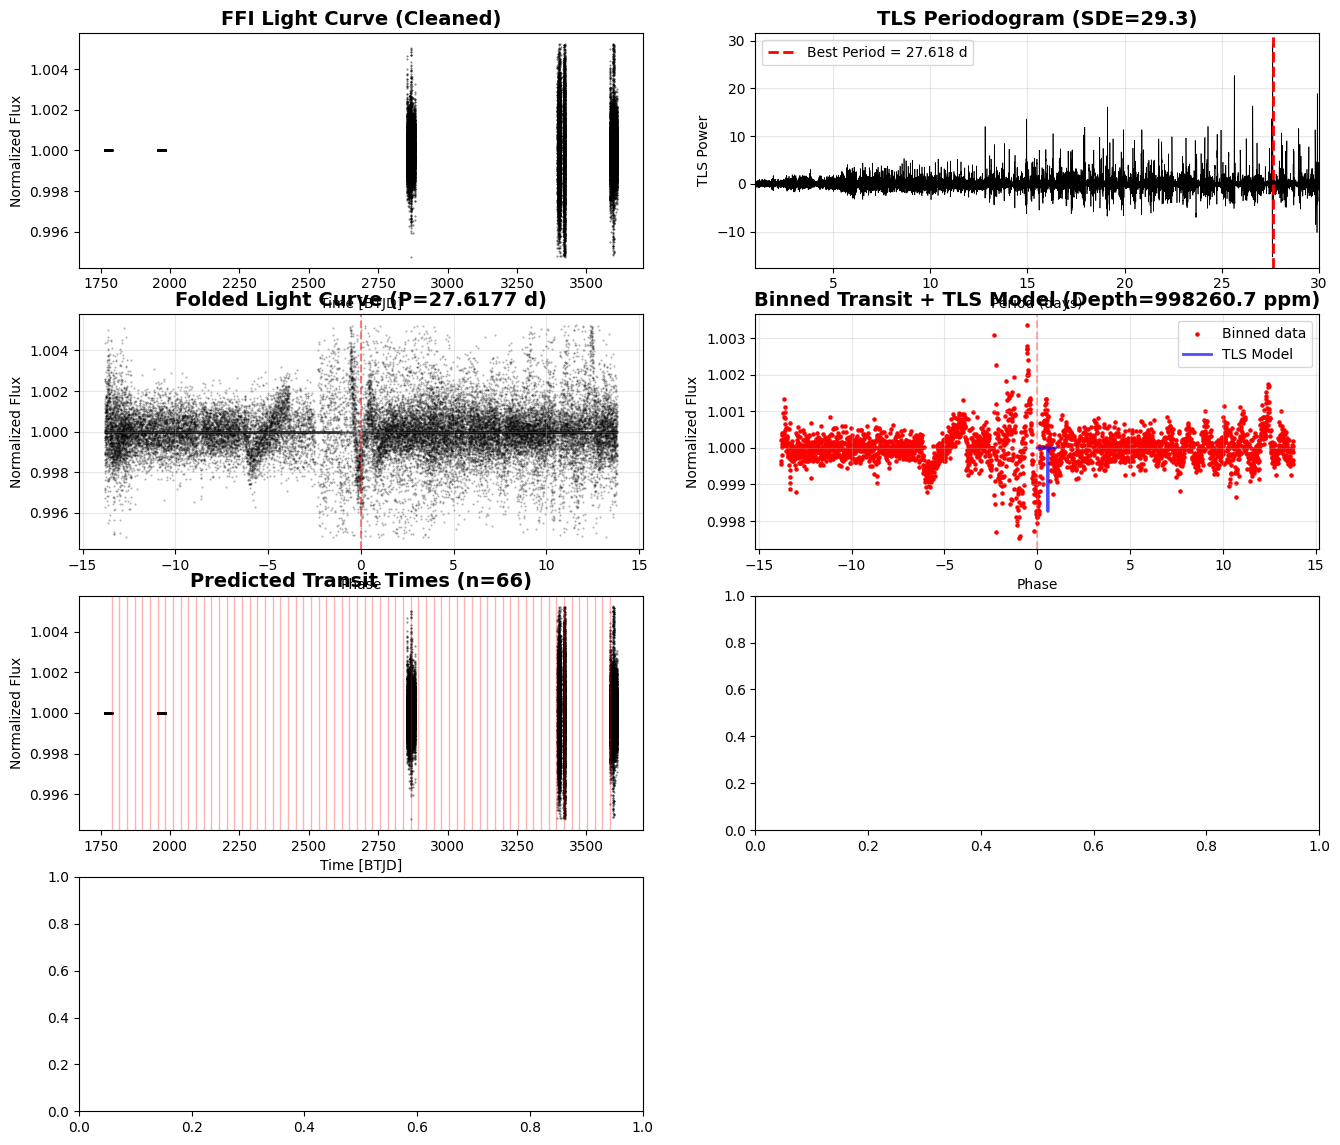

In [24]:
   # Example 2: Single target search (uncomment to use)
print("\n\nEXAMPLE 2: Single target search")
results = ffi_planet_search_tls(283722336, period_min=1, period_max=30, plot=True)
    
    # Example 3: Batch search (uncomment to use)
    # print("\n\nEXAMPLE 3: Batch search")
    # test_tics = [279741379, 425997655, 52368076]
    # df, all_results = batch_ffi_search_tls(test_tics, period_min=1, period_max=30)